In [1]:
import glob
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import re
import numpy as np
import chess

In [2]:
training_images = glob.glob("data/train/*.jpeg")
testing_images = glob.glob("data/test/*.jpeg")

In [3]:
# Piece_type = ['King','Queen','Rook','Bishop','Knight','Pawn']
# Capital = White, Normal = Black
# 0 for empty squares
LABELS = "0prbnkqPRBNKQ" 

IMAGE_HEIGHTS = 400
IMAGE_WIDTHS = 400
N_RANKS = 8
SQUARE_SIZE = IMAGE_HEIGHTS // N_RANKS


# Sorting out data 

In [4]:
def get_image_fen(img_path: str | Path):
    if not isinstance(img_path, Path):
        img_path = Path(img_path)

    fn = img_path.stem
    return fn.replace("-", "/")

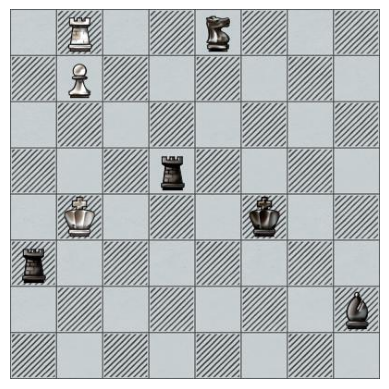

1R2n3/1P6/8/3r4/1K3k2/r7/7b/8


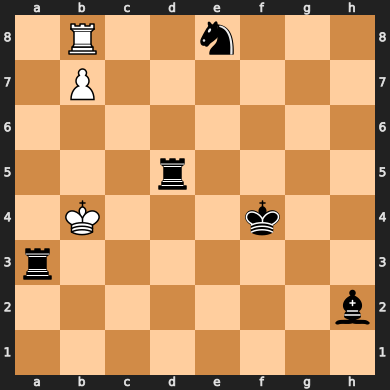

In [5]:
fen = get_image_fen(training_images[0])
plt.imshow(cv2.imread(training_images[0]))
plt.axis('off')
plt.show()
print(fen)
chess.Board(fen)


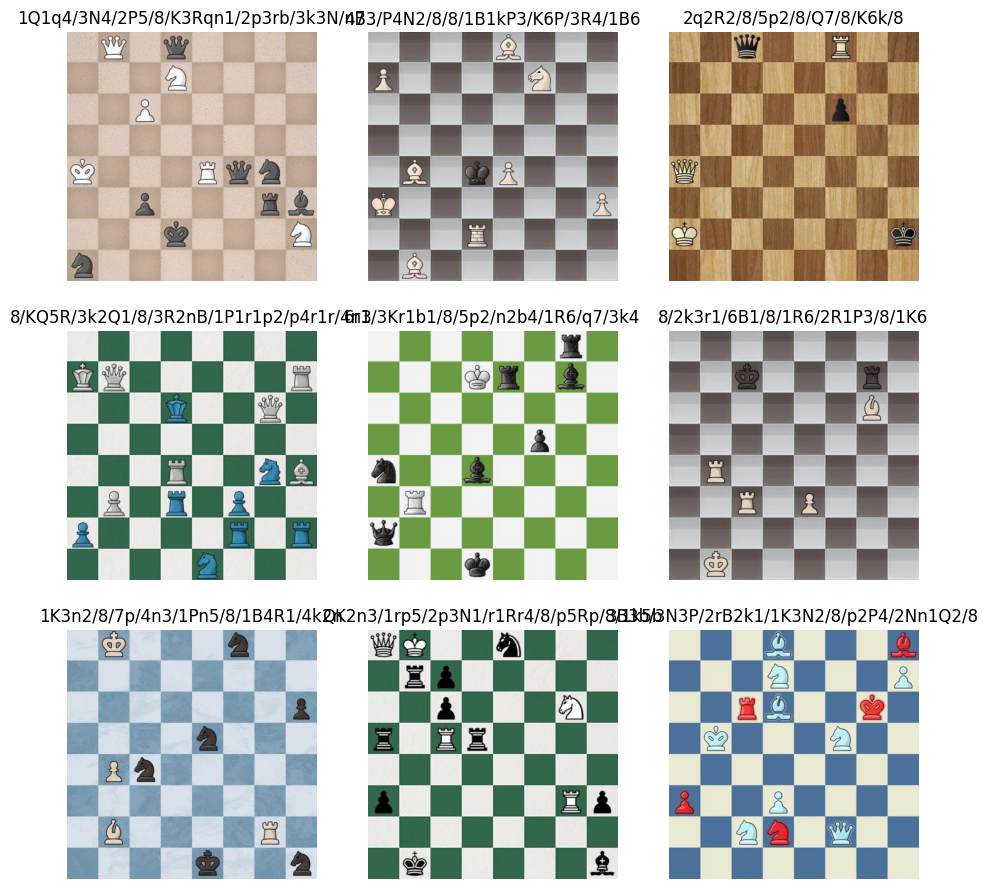

In [6]:
samples = random.sample(training_images, 9)
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns * rows + 1), samples):
    fig.add_subplot(rows, columns, i)
    fen = get_image_fen(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(fen)

plt.show()

In [26]:
def fen2labels(fen: str, encode: bool=False) -> list[str] | list[int]:
    ranks = fen.split("/")
    
    labels: list[str] = []
    for rank in ranks:
        for square in rank:
            if square.isdigit():
                labels.extend(["0"] * int(square))
            elif square in LABELS:
                labels.append(square)

    if encode:
        return [LABELS.index(label) for label in labels]
    
    return labels


def labels2fen(labels: list[str], encoded:bool=False) -> str:

    if encoded:
        labels = [LABELS[label] for label in labels]
        
    fen = "/".join("".join(row) for row in np.reshape(labels, (8, 8)))
    return re.sub(r"0+", lambda m: str(len(m.group(0))), fen)

test_fen = "1R2n3/1P6/8/3r4/1K3k2/r7/7b/8"
labels = fen2labels(test_fen)
output_fen = labels2fen(labels)

assert(test_fen == output_fen)

In [8]:
def board2squares(board_img):
    squares = []

    for row in range(N_RANKS):
        for col in range(N_RANKS):
            x1, y1 = col * SQUARE_SIZE, row * SQUARE_SIZE
            x2, y2 = x1 + SQUARE_SIZE, y1 + SQUARE_SIZE

            squares.append(board_img[y1:y2, x1:x2])

    return squares

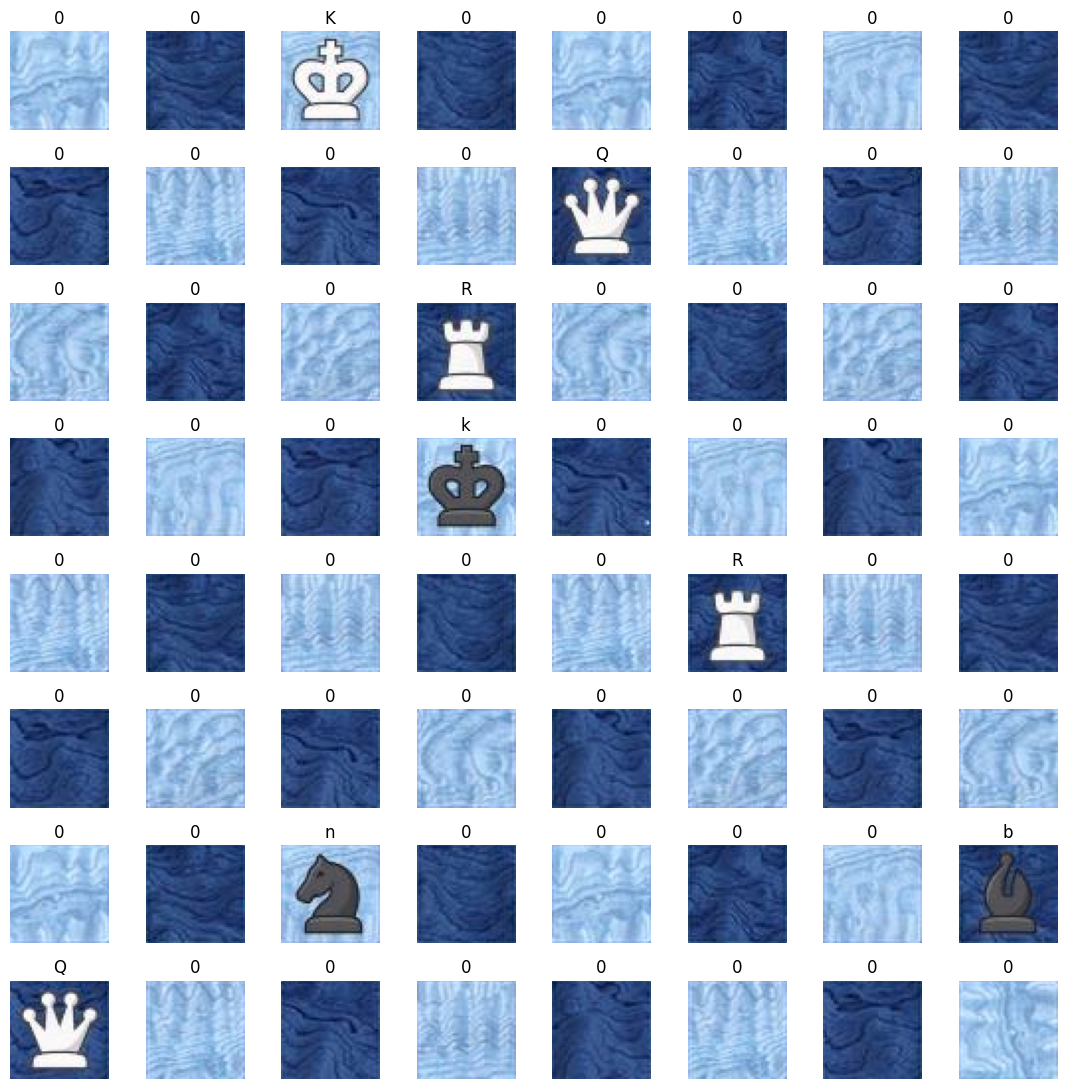

In [9]:
random_board = random.choice(training_images)

fen = get_image_fen(random_board)
img = cv2.imread(random_board)
squares = board2squares(img)
labels = fen2labels(fen)

fig = plt.figure(figsize=(11, 11))
for i, (square, label) in enumerate(zip(squares, labels)):
    fig.add_subplot(N_RANKS, N_RANKS, i+1)
    plt.imshow(square)
    plt.axis("off")
    plt.title(label)

plt.tight_layout()
plt.show()

# Making Pytorch components

In [ ]:
from torch.utils.data import Dataset, DataLoader
from chessing.dataset import ChessDataset

transform = transforms.Compose([
    transforms.ToTensor(),        
    transforms.Normalize((0.5,), (0.5,)) 
])

training_dataset = ChessDataset(training_images, transform=transform)
train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)


In [ ]:
from chessing.model import ChessPieceClassifier

model = ChessPieceClassifier()

In [ ]:
from torch import nn, optim
from chessing.training import train_model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move model to GPU if available
device = torch.device("mps")
model.to(device)

# Start training
train_model(model, train_loader, num_epochs=1, log_interval=10)

Epoch [1/1], Step [10/5000], Loss: 0.0007, Accuracy: 0.9997
Epoch [1/1], Step [20/5000], Loss: 0.0006, Accuracy: 0.9998
Epoch [1/1], Step [30/5000], Loss: 0.0004, Accuracy: 0.9998
Epoch [1/1], Step [40/5000], Loss: 0.0004, Accuracy: 1.0000
Epoch [1/1], Step [50/5000], Loss: 0.0004, Accuracy: 0.9999
Epoch [1/1], Step [60/5000], Loss: 0.0003, Accuracy: 1.0000
Epoch [1/1], Step [70/5000], Loss: 0.0006, Accuracy: 0.9998
Epoch [1/1], Step [80/5000], Loss: 0.0006, Accuracy: 0.9997
Epoch [1/1], Step [90/5000], Loss: 0.0003, Accuracy: 0.9999
Epoch [1/1], Step [100/5000], Loss: 0.0007, Accuracy: 0.9998
Epoch [1/1], Step [110/5000], Loss: 0.0004, Accuracy: 0.9999
Epoch [1/1], Step [120/5000], Loss: 0.0006, Accuracy: 0.9999
Epoch [1/1], Step [130/5000], Loss: 0.0003, Accuracy: 1.0000
Epoch [1/1], Step [140/5000], Loss: 0.0003, Accuracy: 1.0000
Epoch [1/1], Step [150/5000], Loss: 0.0005, Accuracy: 0.9999
Epoch [1/1], Step [160/5000], Loss: 0.0007, Accuracy: 0.9997
Epoch [1/1], Step [170/5000], Los

KeyboardInterrupt: 

In [42]:

# Set device
device = torch.device("mps")
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Preprocessing transform: Same as during training
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Apply normalization, adapt to your training data
])

# Function for inference
def infer_image(image_path):
    # 1. Load the image using OpenCV
    board_img = cv2.imread(image_path)

    # 2. Convert the image to grayscale (if needed)
    board_img = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)

    # 3. Use the `board2squares` function to get the 64 squares from the board image
    square_images = board2squares(board_img)

    # 4. Apply preprocessing to each square image and put it in a batch
    inputs = [transform(square) for square in square_images]
    inputs = torch.stack(inputs).unsqueeze(0).to(device)  # Add batch dimension

    # 5. Get predictions from the model
    with torch.no_grad():
        outputs = model(inputs)
    
    # 6. Get the predicted labels for each square (index of the max logit)
    _, predicted = torch.max(outputs, 2)  # Predicted labels
    
    # 7. Convert labels back to FEN string
    predicted_labels = predicted.cpu().numpy()  # Get the predicted labels as numpy array
    fen = labels2fen(predicted_labels[0], encoded=True)  # Convert the labels to FEN notation
    
    return fen


# Example usage:
sample = random.choice(testing_images)
fen_string = infer_image(sample)
print("Predicted FEN:", fen_string)

Predicted FEN: 1N5n/p7/7r/2N4b/2K1k3/Pp6/4N2b/3Q4


In [47]:
sample = random.sample(testing_images, 1000)

errors = []
for img in sample:
    fen = get_image_fen(img)
    predicted_fen = infer_image(img)
    if fen != predicted_fen:
        errors.append((img, fen, predicted_fen))

print(f"Total boards incorrect: {len(errors)}")

Total boards incorrect: 0


True FEN: 6B1/N2p4/2b5/K4N2/1R3r2/4k1NP/6b1/3bB3
Predicted FEN: 6B1/N2p4/2b5/K4N2/1R3r2/4k1NP/6b1/3bB3


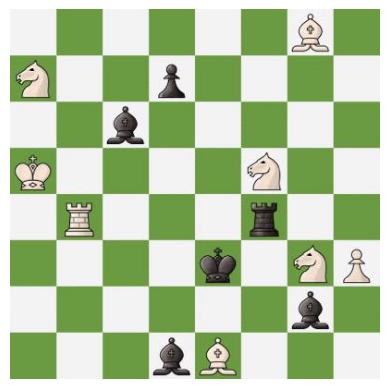

In [55]:
sample = random.choice(testing_images)

img = cv2.imread(sample)
fen = get_image_fen(sample)
predicted_fen = infer_image(sample)

print("True FEN:", fen)
print("Predicted FEN:", predicted_fen)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()